In [112]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# For preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline

from sklearn.compose import ColumnTransformer
from sklearn.discriminant_analysis import StandardScaler
from sklearn.preprocessing import OneHotEncoder


# For modeling
from sklearn.ensemble import RandomForestRegressor

# For evaluation
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


# To ignore warnings
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline


In [113]:
data = pd.read_csv('data/cleaned_rental_data.csv')
data.head()

,city,area_sqm,num_rooms,num_bathrooms,num_parking_spaces,floor_level,allows_animals,is_furnished,hoa_fee_brl,monthly_rent_brl,property_tax_brl,fire_insurance_brl,total_monthly_cost_brl
0,São Paulo,70,2,1,1,7.0,acept,furnished,2065,3300,211,42,5618
1,São Paulo,320,4,4,0,20.0,acept,not furnished,1200,4960,1750,63,7973
2,Porto Alegre,80,1,1,1,6.0,acept,not furnished,1000,2800,0,41,3841
3,Porto Alegre,51,2,1,0,2.0,acept,not furnished,270,1112,22,17,1421
4,São Paulo,25,1,1,0,1.0,not acept,not furnished,0,800,25,11,836


### Preprocessing

#### 1. Feature Engineering

In [114]:
# data['high_hoa_fee'] = data['hoa_fee_brl'].apply(
#     lambda x: 1 if x > data['hoa_fee_brl'].median() else 0
# )

data['calculated_total'] = data['monthly_rent_brl'] + data['hoa_fee_brl'] + data['property_tax_brl']
comparison = data[['total_monthly_cost_brl', 'calculated_total']].head()
print(comparison)


   total_monthly_cost_brl  calculated_total
0                    5618              5576
1                    7973              7910
2                    3841              3800
3                    1421              1404
4                     836               825


#### 2. Separation of data

In [115]:
categorical_features = ['city', 'allows_animals', 'is_furnished']
numerical_features = [
    'area_sqm',           # Area in square meters
    'num_rooms',          # Number of rooms
    'num_bathrooms',      # Number of bathrooms
    'num_parking_spaces', # Number of parking spaces
    'floor_level',        # Floor level of the apartment
    # 'hoa_fee_brl',        # HOA fee in Brazilian reals
    'fire_insurance_brl', # Fire insurance cost in BRL
    'property_tax_brl',   # Property tax in BRL
    # 'monthly_rent_brl',   # Rent amount in BRL
]

# Q1 = data['monthly_rent_brl'].quantile(0.25)
# Q3 = data['monthly_rent_brl'].quantile(0.75)
# IQR = Q3 - Q1

# data = data[(data['monthly_rent_brl'] >= Q1 - 1.5 * IQR) & (data['monthly_rent_brl'] <= Q3 + 1.5 * IQR)]

# remove hoa_fee_brl and monthly_rent_brl from original data
data = data.drop(['hoa_fee_brl', 'monthly_rent_brl'], axis=1)



In [116]:

numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='first')) # One-hot encode the categorical columns
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

**MAE (Cross-Validation):**
Linear Regression: 1834.5287
Random Forest: 923.9716
Gradient Boosting: 1464.5591

**Linear Regression**
MAE: 1431.8416
RMSE: 1936.7076
R²: 0.8117

**Random Forest**
MAE: 669.5676
RMSE: 1902.4187
R²: 0.8183

**Gradient Boosting**
MAE: 1135.7043
RMSE: 5821.6972
R²: -0.7012

               Model MAE (Test) RMSE (Test) R² (Test)   MAE (CV)   RMSE (CV)  \
0  Linear Regression  1431.8416   1936.7076    0.8117  1834.5287  17760.2440   
1      Random Forest   669.5676   1902.4187    0.8183   923.9716   8350.8872   
2  Gradient Boosting  1135.7043   5821.6972   -0.7012  1464.5591  14200.1085   

   R² (CV)  
0   0.3926  
1   0.3986  
2  -3.4478  


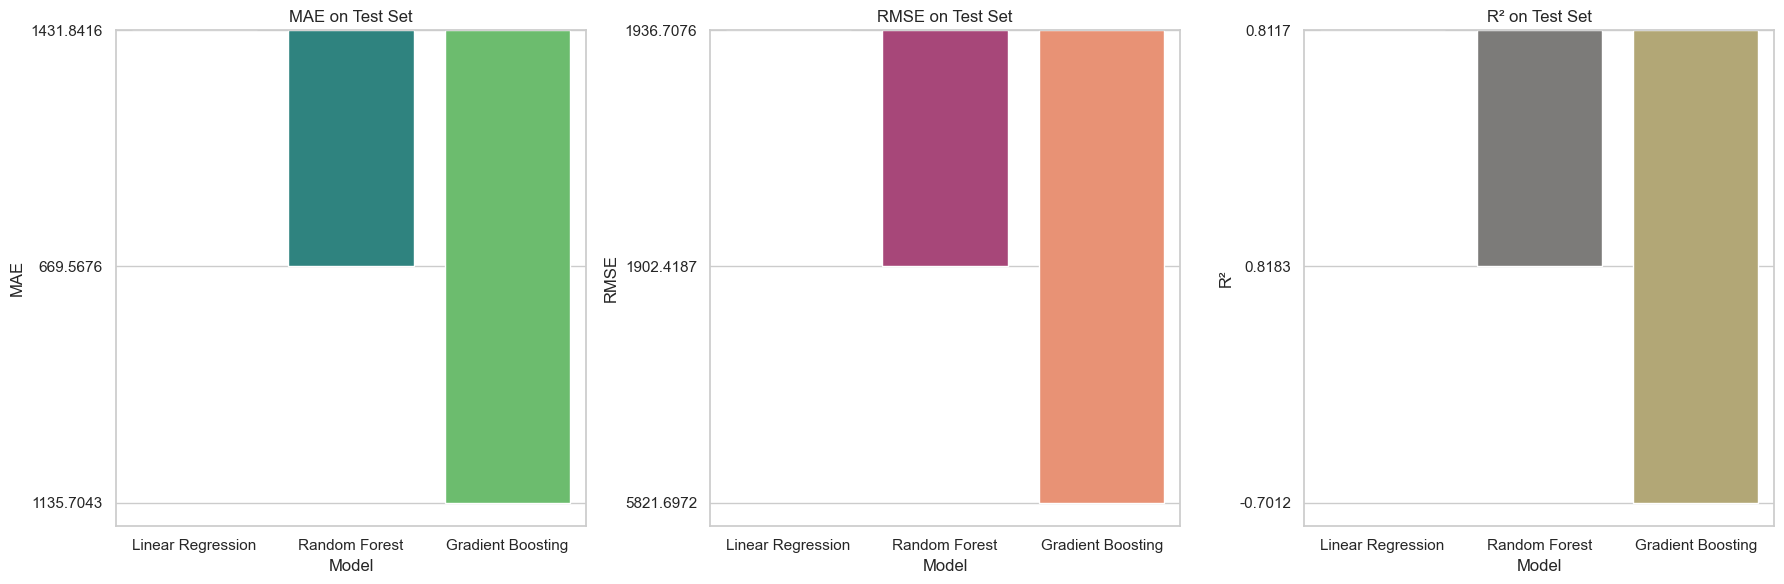

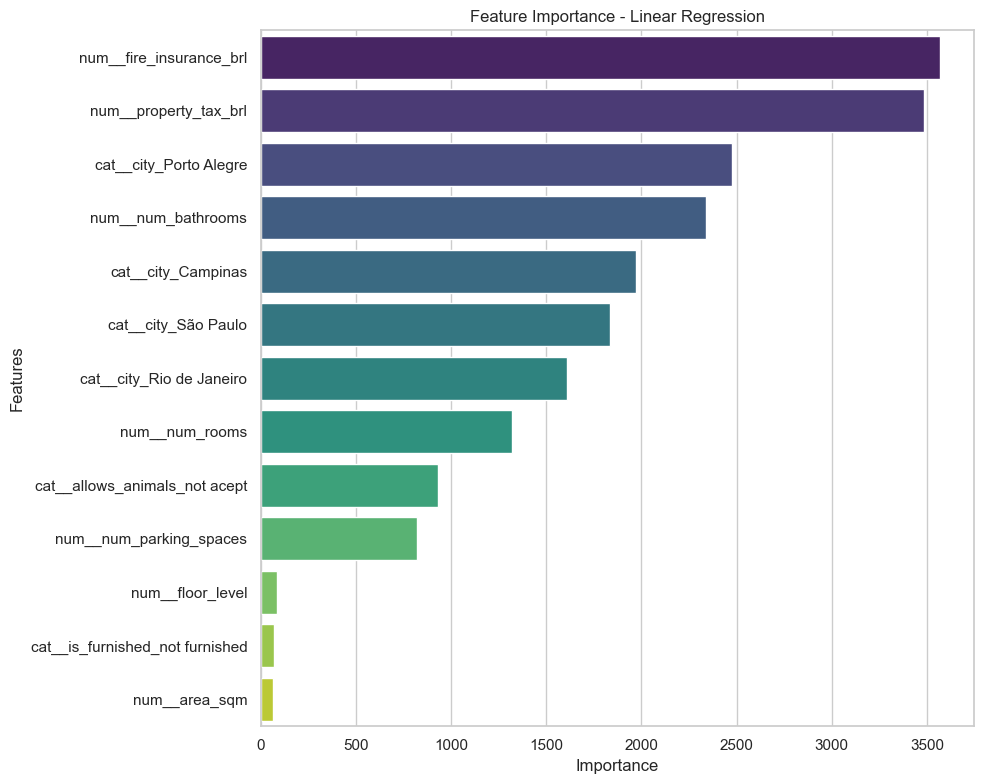

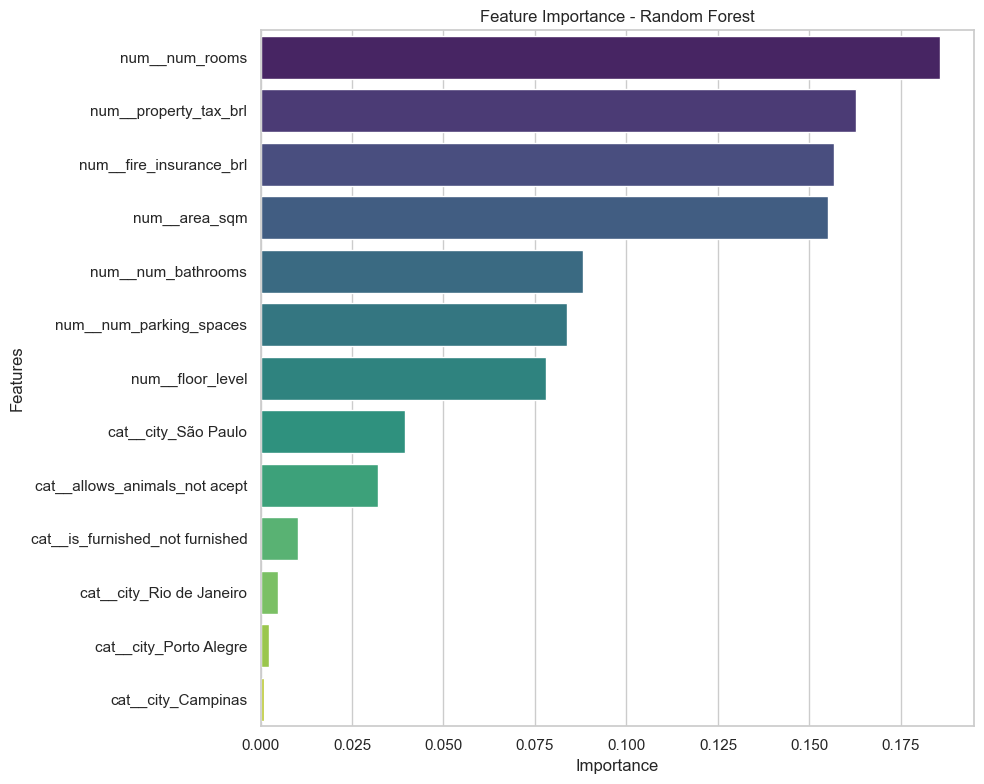

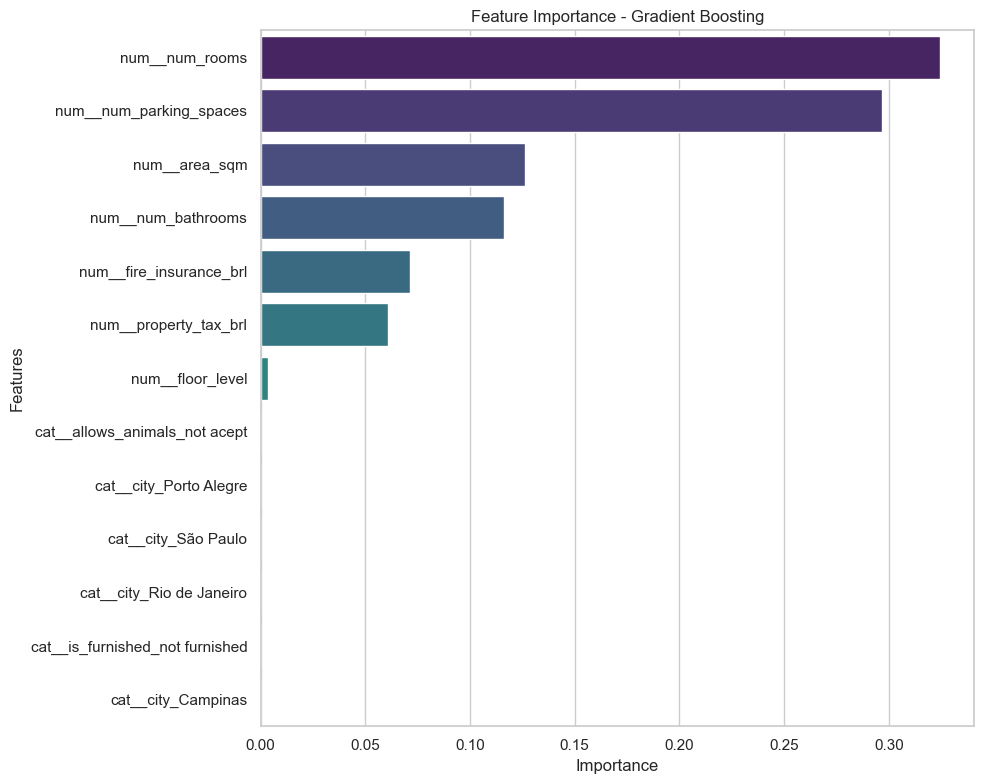

In [122]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Define models
linear_model = LinearRegression()
random_forest_model = RandomForestRegressor(
    n_estimators=500,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features='sqrt',
    max_depth=50,
    random_state=42
)
gradient_boosting_model = GradientBoostingRegressor(random_state=42)

# Prepare X (features) and y (target)
X = data.drop('total_monthly_cost_brl', axis=1)
y = data['total_monthly_cost_brl']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define pipelines for each model
linear_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', linear_model)
])

random_forest_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', random_forest_model)
])

gradient_boosting_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', gradient_boosting_model)
])

pipelines = {
    'Linear Regression': linear_pipeline,
    'Random Forest': random_forest_pipeline,
    'Gradient Boosting': gradient_boosting_pipeline
}

# Evaluate models using cross-validation
linear_scores_cv = cross_val_score(linear_pipeline, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
rf_scores_cv = cross_val_score(random_forest_pipeline, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
gb_scores_cv = cross_val_score(gradient_boosting_pipeline, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')

print("**MAE (Cross-Validation):**")
print(f"Linear Regression: {-linear_scores_cv.mean():.4f}")
print(f"Random Forest: {-rf_scores_cv.mean():.4f}")
print(f"Gradient Boosting: {-gb_scores_cv.mean():.4f}\n")

# Fit the pipelines
linear_pipeline.fit(X_train, y_train)
random_forest_pipeline.fit(X_train, y_train)
gradient_boosting_pipeline.fit(X_train, y_train)

# Make predictions
y_pred_linear = linear_pipeline.predict(X_test)
y_pred_rf = random_forest_pipeline.predict(X_test)
y_pred_gb = gradient_boosting_pipeline.predict(X_test)

# Define evaluation function
def evaluate_model(y_true, y_pred, model_name):
    """
    Calculates and prints MAE, RMSE, and R² for a given model.
    """
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"**{model_name}**")
    print(f"MAE: {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R²: {r2:.4f}\n")

# Evaluate each model on the test set
evaluate_model(y_test, y_pred_linear, 'Linear Regression')
evaluate_model(y_test, y_pred_rf, 'Random Forest')
evaluate_model(y_test, y_pred_gb, 'Gradient Boosting')

# Create a DataFrame of metrics
def create_metrics_dataframe(pipelines, X_train, y_train, X_test, y_test):
    """
    Creates a DataFrame containing evaluation metrics for each model.
    """
    metrics = {
        'Model': [],
        'MAE (Test)': [],
        'RMSE (Test)': [],
        'R² (Test)': [],
        'MAE (CV)': [],
        'RMSE (CV)': [],
        'R² (CV)': []
    }
    
    for name, pipeline in pipelines.items():
        # Predictions on test set
        y_pred = pipeline.predict(X_test)
        
        # Test metrics
        mae_test = mean_absolute_error(y_test, y_pred)
        rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
        r2_test = r2_score(y_test, y_pred)
        
        # Cross-validation metrics
        mae_cv = -cross_val_score(pipeline, X_train, y_train, cv=5, scoring='neg_mean_absolute_error').mean()
        rmse_cv = np.sqrt(-cross_val_score(pipeline, X_train, y_train, cv=5, scoring='neg_mean_squared_error').mean())
        r2_cv = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='r2').mean()
        
        # Append to metrics
        metrics['Model'].append(name)
        metrics['MAE (Test)'].append(mae_test)
        metrics['RMSE (Test)'].append(rmse_test)
        metrics['R² (Test)'].append(r2_test)
        metrics['MAE (CV)'].append(mae_cv)
        metrics['RMSE (CV)'].append(rmse_cv)
        metrics['R² (CV)'].append(r2_cv)
    
    metrics_df = pd.DataFrame(metrics)
    
    # Format the metrics
    metrics_df['MAE (Test)'] = metrics_df['MAE (Test)'].map("{:.4f}".format)
    metrics_df['RMSE (Test)'] = metrics_df['RMSE (Test)'].map("{:.4f}".format)
    metrics_df['R² (Test)'] = metrics_df['R² (Test)'].map("{:.4f}".format)
    metrics_df['MAE (CV)'] = metrics_df['MAE (CV)'].map("{:.4f}".format)
    metrics_df['RMSE (CV)'] = metrics_df['RMSE (CV)'].map("{:.4f}".format)
    metrics_df['R² (CV)'] = metrics_df['R² (CV)'].map("{:.4f}".format)
    
    return metrics_df

metrics_df = create_metrics_dataframe(pipelines, X_train, y_train, X_test, y_test)

print(metrics_df)

# Define plotting functions
def plot_metrics(metrics_df):
    """
    Plots MAE, RMSE, and R² for each model.
    """
    sns.set(style="whitegrid")
    plt.figure(figsize=(18, 6))
    
    # MAE
    plt.subplot(1, 3, 1)
    sns.barplot(x='Model', y='MAE (Test)', data=metrics_df, palette='viridis')
    plt.title('MAE on Test Set')
    plt.ylabel('MAE')
    plt.xlabel('Model')
    
    # RMSE
    plt.subplot(1, 3, 2)
    sns.barplot(x='Model', y='RMSE (Test)', data=metrics_df, palette='magma')
    plt.title('RMSE on Test Set')
    plt.ylabel('RMSE')
    plt.xlabel('Model')
    
    # R²
    plt.subplot(1, 3, 3)
    sns.barplot(x='Model', y='R² (Test)', data=metrics_df, palette='cividis')
    plt.title('R² on Test Set')
    plt.ylabel('R²')
    plt.xlabel('Model')
    
    plt.tight_layout()
    plt.show()

def plot_feature_importance(pipelines, preprocessor, X_train):
    """
    Plots feature importance for each model.
    """
    for name, pipeline in pipelines.items():
        model = pipeline.named_steps['model']
        
        # Get feature names after preprocessing
        try:
            feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()
        except AttributeError:
            feature_names = X_train.columns  # Fallback if get_feature_names_out() is not available
        
        if hasattr(model, 'feature_importances_'):
            importances = model.feature_importances_
        elif hasattr(model, 'coef_'):
            importances = np.abs(model.coef_)
        else:
            print(f"Cannot retrieve feature importances for {name}.")
            continue
        
        # Create a DataFrame for plotting
        fi_df = pd.DataFrame({
            'Feature': feature_names,
            'Importance': importances
        }).sort_values(by='Importance', ascending=False).head(20)  # Top 20 features
        
        # Plot
        plt.figure(figsize=(10, 8))
        sns.barplot(x='Importance', y='Feature', data=fi_df, palette='viridis')
        plt.title(f'Feature Importance - {name}')   
        plt.xlabel('Importance')
        plt.ylabel('Features')
        plt.tight_layout()
        plt.show()

# Plot the metrics
plot_metrics(metrics_df)

# Plot feature importance for each model
plot_feature_importance(pipelines, preprocessor, X_train)


In [119]:
from sklearn.model_selection import RandomizedSearchCV

# Define the parameter grid
param_grid = {
    'model__n_estimators': [100, 200, 300, 400, 500],
    'model__max_depth': [None, 10, 20, 30, 40, 50],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4],
    'model__max_features': ['auto', 'sqrt', 'log2']
}

# Initialize RandomizedSearchCV
rf_random_search = RandomizedSearchCV(
    estimator=random_forest_pipeline,
    param_distributions=param_grid,
    n_iter=50,
    cv=5,
    scoring='neg_mean_absolute_error',
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Fit the random search model
rf_random_search.fit(X_train, y_train)

# Best parameters and best score
print("Best Parameters for Random Forest:")
print(rf_random_search.best_params_)
print(f"Best CV MAE: {-rf_random_search.best_score_:.4f}")

# Update the pipeline with the best estimator
best_random_forest = rf_random_search.best_estimator_


Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END model__max_depth=40, model__max_features=log2, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=100; total time=   0.5s
[CV] END model__max_depth=40, model__max_features=log2, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=100; total time=   0.5s
[CV] END model__max_depth=40, model__max_features=log2, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=100; total time=   0.5s
[CV] END model__max_depth=40, model__max_features=log2, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=100; total time=   0.5s
[CV] END model__max_depth=40, model__max_features=log2, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=100; total time=   0.6s
[CV] END model__max_depth=10, model__max_features=log2, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=300; total time=   1.3s
[CV

In [121]:
best_r2 = rf_random_search.best_estimator_.score(X_test, y_test)
print(f"Best R² on test set: {best_r2:.4f}")

Best R² on test set: 0.8183
